## MiniVGGNet CNN
This model is a lot more complex than the ShallowNet one. 

In [26]:
#imports and CUDA check
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using: ", device)
print("CUDA Available: ", torch.cuda.is_available())
print(torch.version.cuda)

Using:  cuda
CUDA Available:  True
12.1


### MiniVGGNet Model

First conv block
- 2 conv layers (3x3, 32 filters)
- ReLu activation (discards noise)
- BatchNorm (normalizes activation for efficiency)
- Max Pool (downsamples dimensions)
- Dropout 25% (reduces overfitting)

Second block
- 2 conv layers (3x3, 64 filters)
- BatchNorm
- MaxPool
- Dropout 25%

Final
- flatten (1D vector)
- FC (512 neurons, 64 feature maps * 8x8 spacial dimensions)
- Batch norm (for FC)
- Droupout 50%
- Final FC (with number of classes)

In [17]:
class MiniVGGNet(nn.Module):
    def __init__(self, num_classes=10):
        super(MiniVGGNet, self).__init__()

        # first block: 32 filters, 3x3 kernel
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.relu = nn.ReLU() # discards noise
        self.batchnorm1 = nn.BatchNorm2d(32) # batch normalization - stabilization
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # max val per kernel
        self.dropout1 = nn.Dropout(0.25) # 25% chance of neuron deactivation, prevents overfitting

        # second block: 64 filters, 3x3 kernel
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)
        
        self.flatten = nn.Flatten() # converts feature maps to 1D vector
        self.fc1 = nn.Linear(64 * 8 * 8, 512) # first fc layer (64 feature maps * 8x8)
        self.batchnorm3 = nn.BatchNorm1d(512) # batch norm for FC
        self.dropout3 = nn.Dropout(0.5) # 50% chance neuron deactivation

        self.fc2 = nn.Linear(512, num_classes) #Cifar-10 has 10 classes

    def forward(self, x):
        # first block
        x = self.relu(self.batchnorm1(self.conv1(x)))
        x = self.relu(self.batchnorm1(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x) 

        # Second block
        x = self.relu(self.batchnorm2(self.conv3(x)))
        x = self.relu(self.batchnorm2(self.conv4(x)))
        x = self.pool2(x) 
        x = self.dropout2(x) 

        # fc layers
        x = self.flatten(x) 
        x = self.relu(self.batchnorm3(self.fc1(x)))
        x = self.dropout3(x)
        x = self.fc2(x)
        return x

### CIFER10 Dataset

In [18]:
# CIFER10 Dataset import
transform = transforms.Compose([ 
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize dataset
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


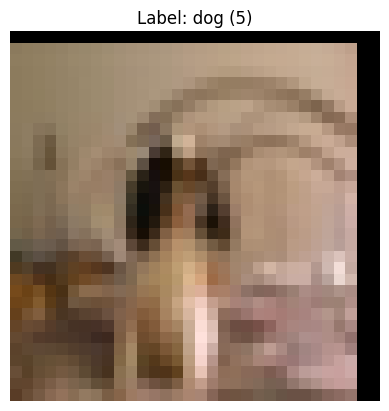

In [19]:
# displays random sample from dataset to make sure it imported correctly
dataiter = iter(train_loader)
images, labels = next(dataiter)

cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

img = images[0].permute(1, 2, 0).numpy() 
img = img * 0.5 + 0.5  
class_label = cifar10_classes[labels[0].item()]
plt.imshow(img)
plt.title(f"Label: {class_label} ({labels[0].item()})")
plt.axis("off")
plt.show()

### Model Training
Same loop as in ShallowNet program, but I added time to track how long each epoch takes

In [20]:
# initialization
model = MiniVGGNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

train_losses, test_losses = [], []
train_acc, test_acc = [], []

num_epochs = 40  # Number of epochs

In [21]:
import time  # Import time module
print("Training Model (MiniVGGNet)...")

for epoch in range(num_epochs):
    start_time = time.time()  # Start timer

    model.train()  # Puts model in training mode
    correct, total, epoch_loss = 0, 0, 0  # Initialize tracking variables

    # Iterate through dataset in batches
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # move to GPU if available
        optimizer.zero_grad()  # zero gradients to prevent accumulation
        outputs = model(images)  # fgorward pass, get predictions
        loss = criterion(outputs, labels)  # compute loss between predictions and true labels
        loss.backward()  # backward pass (compute gradients)
        optimizer.step()  # Update parameters (weights)

        # track loss and accuracy
        epoch_loss += loss.item()  # add batch loss to epoch total
        _, predicted = torch.max(outputs, 1)  # get predicted class
        total += labels.size(0)  # Update total count
        correct += (predicted == labels).sum().item()  # count correct predictions

    # Store average loss and accuracy for this epoch
    train_losses.append(epoch_loss / len(train_loader))
    train_acc.append(correct / total)

    # Evaluate model on test set
    model.eval()  # Put model in evaluation mode
    correct, total, test_loss = 0, 0, 0  # Reset evaluation tracking variables

    # Disable gradient computation (reduces memory usage & speeds up inference)
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device) 
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() 
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # store the test loss and accuracy
    test_losses.append(test_loss / len(test_loader))
    test_acc.append(correct / total)

    end_time = time.time()  # End timer
    epoch_duration = end_time - start_time  # Calculate epoch time

    # Print epoch stats
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, "
          f"Train Acc: {train_acc[-1]*100:.2f}%, Test Acc: {test_acc[-1]*100:.2f}%, "
          f"Time: {epoch_duration:.2f} seconds")

Training Model (MiniVGGNet)...
Epoch [1/40], Train Loss: 1.6136, Train Acc: 41.63%, Test Acc: 24.93%, Time: 65.96 seconds
Epoch [2/40], Train Loss: 1.2581, Train Acc: 54.76%, Test Acc: 33.12%, Time: 68.23 seconds
Epoch [3/40], Train Loss: 1.0812, Train Acc: 61.54%, Test Acc: 34.08%, Time: 89.11 seconds


KeyboardInterrupt: 

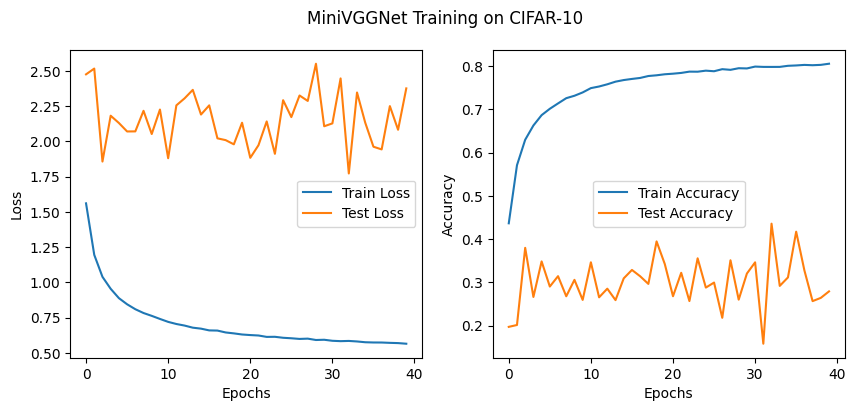

In [15]:
# Plot training history
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_losses, label="Train Loss")
plt.plot(range(num_epochs), test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_acc, label="Train Accuracy")
plt.plot(range(num_epochs), test_acc, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.suptitle("MiniVGGNet Training on CIFAR-10")
plt.show()
